# Generating IC's

In [45]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import os
import analysis as an

We start by generating some white noise $n(\mathbf{x})$

In [80]:
size = 30 # Mpc/h
n_grid = 128
n_grid_half = n_grid // 2
key, noise_key = jax.random.split(jax.random.PRNGKey(1))
rho = jax.random.normal(noise_key, (n_grid, n_grid, n_grid))

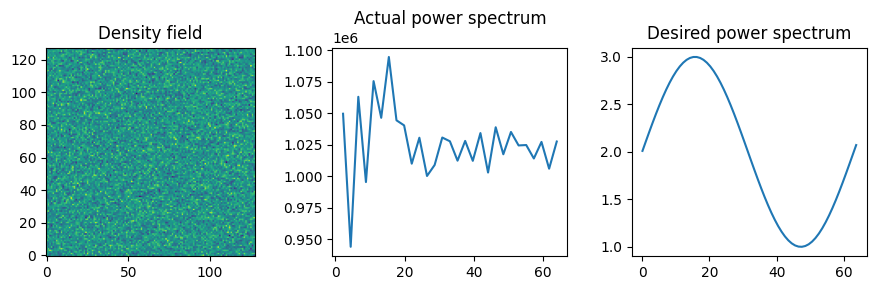

In [96]:
delta = an.overdensity(rho)

power_spectrum = an.PowerSpectrum(N = n_grid, n_bins=30)

k, Pk = power_spectrum(delta)

# lets define a desired power spectrum
k_desired = jnp.linspace(0.1, n_grid, n_grid)
Pk_desired = (jnp.sin(k_desired * 0.1) + 2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta[n_grid//2], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired[:n_grid_half], Pk_desired[:n_grid_half])
ax3.set_title('Desired power spectrum')

plt.tight_layout()


According to Pen et al. (1997), we need to compute the correlation Kernel

$$ 
A(k) = \sqrt{P(k)}.
$$

Then we can convolve the white noise with the correlation Kernel in furier space to generate the density field with the desired power spectrum.

$$
\delta(\mathbf{k}) = n(\mathbf{k}) A(\mathbf{k}).
$$

source : [INITIAL CONDITIONS FOR LARGE COSMOLOGICAL SIMULATIONS](https://arxiv.org/pdf/0804.3536)


In [97]:
# lets compute the correlation Kernel
Ax_lin = jnp.sqrt(Pk_desired)

# first we compute an index grid indicating the coordinates in the linear power spectrum array
# from where we need to read the values for each entry in the correlation kernel
coords = jnp.linspace(-n_grid_half, n_grid_half, n_grid, endpoint=False)
x, y, z = jnp.meshgrid(coords, coords, coords, indexing='ij')
index_grid = jnp.sqrt(x**2 + y**2 + z**2)
index_grid = jnp.abs(index_grid)
index_grid = index_grid.astype(jnp.int32)

# assign the values
Ax = Ax_lin.at[index_grid].get()

# transform to fourier space
delta_k = jnp.fft.fftn(delta)
# shift
delta_k = jnp.fft.fftshift(delta_k)
# apply correlation kernel
delta_k_corr = delta_k * Ax
# shift back
delta_k_corr = jnp.fft.ifftshift(delta_k_corr)
# transform back to real space
delta_corr = jnp.fft.ifftn(delta_k_corr).real

Text(0.5, 1.0, 'Correlation Kernel')

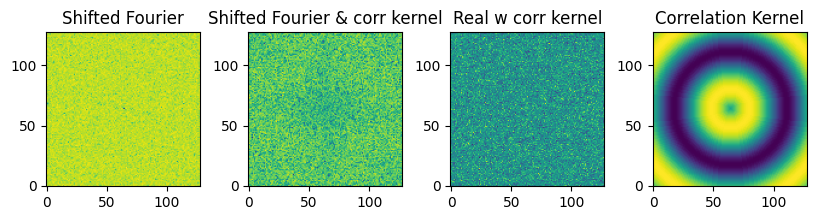

In [98]:

# plot delta_k
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 2))

ax1.imshow(jnp.log10(jnp.abs(delta_k[n_grid//2])), origin='lower')
ax1.set_title('Shifted Fourier')

ax2.imshow(jnp.log10(jnp.abs(delta_k_corr[n_grid//2])), origin='lower')
ax2.set_title('Shifted Fourier & corr kernel')

ax3.imshow(delta_corr[n_grid//2], origin='lower')
ax3.set_title('Real w corr kernel')

ax4.imshow(Ax[n_grid//2], origin='lower')
ax4.set_title('Correlation Kernel')

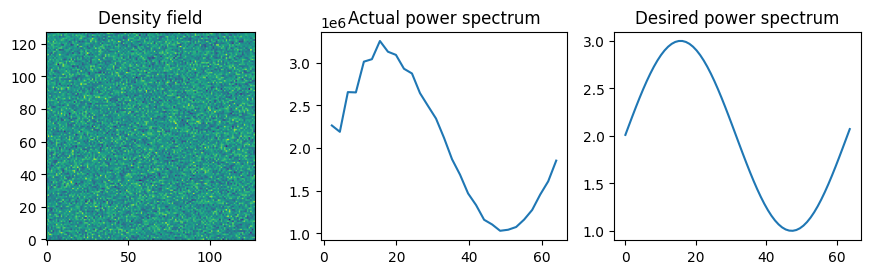

In [99]:
k, Pk = power_spectrum(delta_corr)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta_corr[n_grid_half], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax3.plot(k_desired[:n_grid_half], Pk_desired[:n_grid_half])
ax3.set_title('Desired power spectrum')

plt.tight_layout()